## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import random

# --- REPRODUCIBILITY SETUP ---
# We lock the seeds so every run produces the exact same result.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"Random Seed set to: {SEED}")

# --- DATA LOADING ---
# Updated paths for local execution (relative to notebook location)
# For Jupyter notebooks, use getcwd() to get the current working directory
notebook_dir = os.getcwd()
file_path_excel = os.path.join(notebook_dir, 'Dass21 Dataset.xlsx')
file_path_csv = os.path.join(notebook_dir, 'Dass21_Dataset_Converted.csv')

# Check if file exists to avoid errors
if os.path.exists(file_path_excel):
    print("Loading Excel file...")
    # Load the Excel file
    df = pd.read_excel(file_path_excel)

    # Save as CSV for future use (checkpoint)
    df.to_csv(file_path_csv, index=False)
    print(f"Converted and saved to: {file_path_csv}")

    # Display basic info
    print("\n--- Dataset Info ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    display(df.head())

elif os.path.exists(file_path_csv):
    print(f"Excel file not found. Loading from CSV: {file_path_csv}")
    df = pd.read_csv(file_path_csv)
    
    # Display basic info
    print("\n--- Dataset Info ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    display(df.head())
    
else:
    print(f"Error: Neither Excel file ({file_path_excel}) nor CSV file ({file_path_csv}) found. Please check the paths.")

Random Seed set to: 42
Error: Neither Excel file (c:\Users\User\Documents\GitHub\MachineLearningWithPython\Sessions\DASS21\Dass21 Dataset.xlsx) nor CSV file (c:\Users\User\Documents\GitHub\MachineLearningWithPython\Sessions\DASS21\Dass21_Dataset_Converted.csv) found. Please check the paths.


## Load Dataset

In [4]:
df = pd.read_excel('DASS 21 Dataset.xlsx')

## Data Preprocessing

In [5]:
# --- STEP 1: RENAME COLUMNS ---
# We use index-based renaming to avoid errors with spaces/typos in the original headers
new_column_names = ['Gender', 'Age'] + [f'Q{i}' for i in range(1, 22)]
df.columns = new_column_names

print("Columns renamed to standard format (Gender, Age, Q1...Q21).")

# --- STEP 2: STANDARDIZE CATEGORICAL DATA ---
# Clean Gender column: Remove spaces, make title case (e.g., " male " -> "Male")
df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
print(f"Unique Gender values found: {df['Gender'].unique()}")

# --- STEP 3: DATA CLEANING ---
initial_count = len(df)

# A. Remove Duplicate Rows
df = df.drop_duplicates()
duplicates_removed = initial_count - len(df)

# B. Remove "Straight-Liners" (Invalid Variance)
# Calculate standard deviation across Q1-Q21 for each student
question_cols = [f'Q{i}' for i in range(1, 22)]
row_std = df[question_cols].std(axis=1)
row_mean = df[question_cols].mean(axis=1)

# Logic: Drop if Standard Deviation is 0 AND Mean is not 0
# (We keep Mean=0 because it's valid to have no symptoms)
mask_invalid = (row_std == 0) & (row_mean > 0)
df_clean = df[~mask_invalid].copy()

straight_liners_removed = mask_invalid.sum()

# --- STEP 4: FINAL STATUS REPORT ---
print("\n--- Cleaning Report ---")
print(f"Original Rows: {initial_count}")
print(f"Duplicates Dropped: {duplicates_removed}")
print(f"Straight-Liners Dropped: {straight_liners_removed} (Response bias)")
print(f"Final Clean Rows: {len(df_clean)}")

# Update the main dataframe
df = df_clean

# Show the first few rows of the clean, renamed dataframe
display(df.head())

Columns renamed to standard format (Gender, Age, Q1...Q21).
Unique Gender values found: <StringArray>
['Male', 'Female']
Length: 2, dtype: str

--- Cleaning Report ---
Original Rows: 1641
Duplicates Dropped: 563
Straight-Liners Dropped: 3 (Response bias)
Final Clean Rows: 1075


,Gender,Age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21
0,Male,24,2,2,2,0,3,2,0,3,...,1,3,2,2,3,2,1,3,1,1
1,Female,24,0,2,0,1,2,0,0,0,...,0,0,0,0,2,2,1,3,0,1
2,Male,25,3,3,3,2,3,2,3,3,...,3,1,2,3,2,3,3,2,3,2
3,Male,25,2,3,3,3,3,3,3,3,...,3,3,3,3,2,3,3,3,3,3
4,Male,23,1,3,0,1,1,1,1,1,...,1,1,1,0,2,0,1,0,1,0


## Scoring and Severity Analysis

In [6]:
# --- STEP 1: DEFINE SCALES ---
# Standard DASS-21 mapping
depression_cols = ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']
anxiety_cols    = ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']
stress_cols     = ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']

# --- STEP 2: CALCULATE SCORES ---
# We sum the answers (0-3) and multiply by 2 as per DASS-21 protocol
df['Depression_Score'] = df[depression_cols].sum(axis=1) * 2
df['Anxiety_Score']    = df[anxiety_cols].sum(axis=1) * 2
df['Stress_Score']     = df[stress_cols].sum(axis=1) * 2

# --- STEP 3: DEFINE SEVERITY CATEGORIES ---
# Official DASS-42 Cut-off points (after x2 multiplication)
def get_depression_label(score):
    if score <= 9: return 'Normal'
    elif score <= 13: return 'Mild'
    elif score <= 20: return 'Moderate'
    elif score <= 27: return 'Severe'
    else: return 'Extremely Severe'

def get_anxiety_label(score):
    if score <= 7: return 'Normal'
    elif score <= 9: return 'Mild'
    elif score <= 14: return 'Moderate'
    elif score <= 19: return 'Severe'
    else: return 'Extremely Severe'

def get_stress_label(score):
    if score <= 14: return 'Normal'
    elif score <= 18: return 'Mild'
    elif score <= 25: return 'Moderate'
    elif score <= 33: return 'Severe'
    else: return 'Extremely Severe'

# Apply the labeling functions
df['Depression_Level'] = df['Depression_Score'].apply(get_depression_label)
df['Anxiety_Level']    = df['Anxiety_Score'].apply(get_anxiety_label)
df['Stress_Level']     = df['Stress_Score'].apply(get_stress_label)

# --- STEP 4: CLASS DISTRIBUTION CHECK ---
# We need to know if our dataset is imbalanced (e.g., if everyone is "Normal")
print("--- Class Distribution (Depression) ---")
print(df['Depression_Level'].value_counts())
print("\n--- Class Distribution (Anxiety) ---")
print(df['Anxiety_Level'].value_counts())
print("\n--- Class Distribution (Stress) ---")
print(df['Stress_Level'].value_counts())

# Show the new columns
display(df[['Depression_Score', 'Depression_Level', 'Anxiety_Score', 'Anxiety_Level', 'Stress_Score', 'Stress_Level']].head())

--- Class Distribution (Depression) ---
Depression_Level
Moderate            403
Severe              228
Mild                181
Extremely Severe    138
Normal              125
Name: count, dtype: int64

--- Class Distribution (Anxiety) ---
Anxiety_Level
Extremely Severe    509
Moderate            246
Severe              237
Normal               43
Mild                 40
Name: count, dtype: int64

--- Class Distribution (Stress) ---
Stress_Level
Normal              342
Moderate            301
Mild                245
Severe              165
Extremely Severe     22
Name: count, dtype: int64


,Depression_Score,Depression_Level,Anxiety_Score,Anxiety_Level,Stress_Score,Stress_Level
0,34,Extremely Severe,18,Severe,26,Severe
1,14,Moderate,12,Moderate,2,Normal
2,34,Extremely Severe,38,Extremely Severe,36,Extremely Severe
3,40,Extremely Severe,42,Extremely Severe,40,Extremely Severe
4,10,Mild,12,Moderate,14,Normal


## Reliability Analysis


--- Psychometric Validation (Cronbach's Alpha) ---
Depression Scale Alpha : 0.524 (Should be > 0.7)
Anxiety Scale Alpha    : 0.359 (Should be > 0.7)
Stress Scale Alpha     : 0.437 (Should be > 0.7)


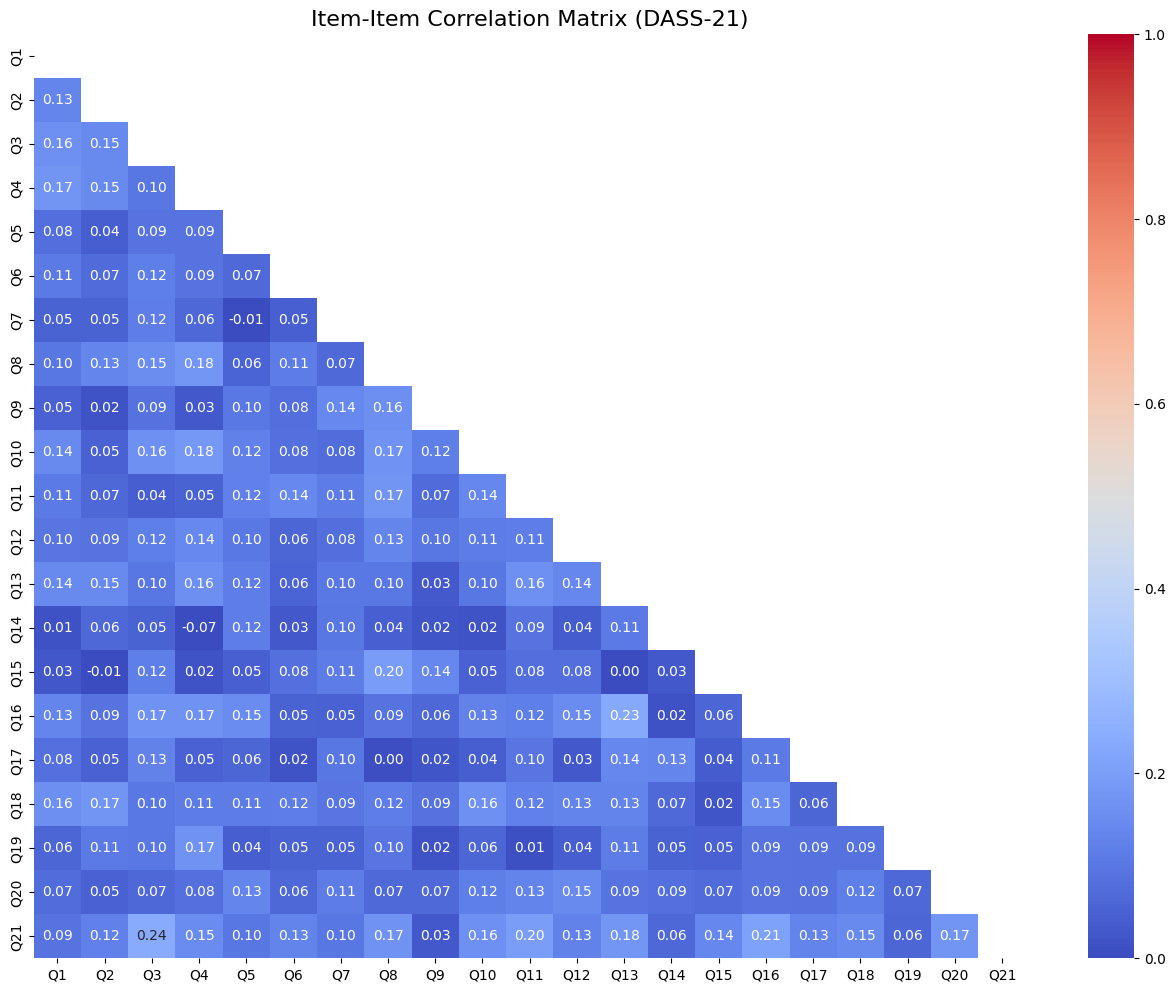

In [7]:
# --- STEP 1: INSTALL STATS LIBRARY ---
# We use !pip to install inside the notebook
!pip install -q pingouin

import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 2: CALCULATE CRONBACH'S ALPHA ---
# We define the subsets again for clarity
d_items = df[['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']]
a_items = df[['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']]
s_items = df[['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']]

# Calculate Alpha
alpha_d = pg.cronbach_alpha(data=d_items)[0]
alpha_a = pg.cronbach_alpha(data=a_items)[0]
alpha_s = pg.cronbach_alpha(data=s_items)[0]

print("\n--- Psychometric Validation (Cronbach's Alpha) ---")
print(f"Depression Scale Alpha : {alpha_d:.3f} (Should be > 0.7)")
print(f"Anxiety Scale Alpha    : {alpha_a:.3f} (Should be > 0.7)")
print(f"Stress Scale Alpha     : {alpha_s:.3f} (Should be > 0.7)")

# --- STEP 3: CORRELATION HEATMAP ---
# We visualize how the 21 questions relate to each other
plt.figure(figsize=(16, 12))
correlation_matrix = df[[f'Q{i}' for i in range(1, 22)]].corr()

# Create a mask to hide the upper triangle (for cleaner look)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1)
plt.title('Item-Item Correlation Matrix (DASS-21)', fontsize=16)
plt.show()

In [8]:
def optimize_scale(df, scale_name, items):
    current_items = items.copy()
    best_alpha = -1.0

    print(f"\n--- Optimizing {scale_name} Scale ---")
    print(f"Starting items: {current_items}")

    while len(current_items) > 3: # Keep at least 3 questions per scale
        # Calculate current alpha
        alpha = pg.cronbach_alpha(data=df[current_items])[0]
        print(f"Current Alpha ({len(current_items)} items): {alpha:.4f}")

        # If we hit our target, stop (optional, but let's try to max it out)
        if alpha > 0.75:
            print("Target Alpha reached!")
            break

        # identifying the "worst" item
        # We calculate alpha for every possible subset with 1 item removed
        candidates = {}
        for item in current_items:
            subset = [x for x in current_items if x != item]
            sub_alpha = pg.cronbach_alpha(data=df[subset])[0]
            candidates[item] = sub_alpha

        # Find which removal gives the HIGHEST alpha
        worst_item = max(candidates, key=candidates.get)
        new_best_alpha = candidates[worst_item]

        # If removing the item IMPROVES alpha, do it.
        # If removing it hurts alpha (drops it), then we have reached the peak.
        if new_best_alpha > alpha:
            print(f"  -> Removing {worst_item} improves Alpha to {new_best_alpha:.4f}")
            current_items.remove(worst_item)
            best_alpha = new_best_alpha
        else:
            print("  -> No further improvement possible.")
            break

    return current_items, alpha

# --- RUN OPTIMIZATION ---
d_items = ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']
a_items = ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']
s_items = ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']

final_d_items, final_alpha_d = optimize_scale(df, "Depression", d_items)
final_a_items, final_alpha_a = optimize_scale(df, "Anxiety", a_items)
final_s_items, final_alpha_s = optimize_scale(df, "Stress", s_items)

print("\n\n=== FINAL OPTIMIZED SCALES ===")
print(f"Depression: {final_d_items} (Alpha: {final_alpha_d:.3f})")
print(f"Anxiety   : {final_a_items} (Alpha: {final_alpha_a:.3f})")
print(f"Stress    : {final_s_items} (Alpha: {final_alpha_s:.3f})")

# --- UPDATE DATAFRAME WITH NEW SCORES ---
# We use ONLY the reliable items for the Machine Learning Phase
df['Depression_Score_Opt'] = df[final_d_items].sum(axis=1)
df['Anxiety_Score_Opt']    = df[final_a_items].sum(axis=1)
df['Stress_Score_Opt']     = df[final_s_items].sum(axis=1)

# Check correlations of the NEW scores
print("\n--- Correlation of Optimized Scores ---")
print(df[['Depression_Score_Opt', 'Anxiety_Score_Opt', 'Stress_Score_Opt']].corr())


--- Optimizing Depression Scale ---
Starting items: ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']
Current Alpha (7 items): 0.5237
  -> No further improvement possible.

--- Optimizing Anxiety Scale ---
Starting items: ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']
Current Alpha (7 items): 0.3594
  -> No further improvement possible.

--- Optimizing Stress Scale ---
Starting items: ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']
Current Alpha (7 items): 0.4368
  -> Removing Q14 improves Alpha to 0.4479
Current Alpha (6 items): 0.4479
  -> No further improvement possible.


=== FINAL OPTIMIZED SCALES ===
Depression: ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21'] (Alpha: 0.524)
Anxiety   : ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20'] (Alpha: 0.359)
Stress    : ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q18'] (Alpha: 0.448)

--- Correlation of Optimized Scores ---
                      Depression_Score_Opt  Anxiety_Score_Opt  \
Depression_Score_Opt              1.000000           0.379528   
Anx

## Feature Engineering and Clustering Preparation

## Cluster Evaluation Metrics with Silhouette Score

The **Silhouette Score** measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1:
- **Close to 1**: The object is well matched to its cluster and far from neighboring clusters.
- **Close to 0**: The object is on or very close to the decision boundary between clusters.
- **Negative**: The object might be assigned to the wrong cluster.

We compute the Silhouette Score for different values of k to validate the choice of k=3 from the Elbow method.

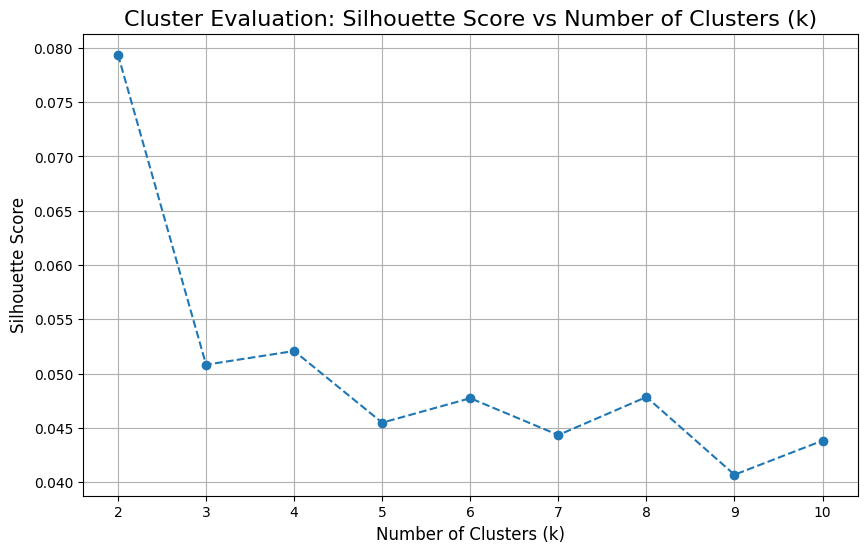


--- Cluster Evaluation (k=3) ---
Silhouette Score: 0.0508
Interpretation: Weak structure


In [17]:
from sklearn.metrics import silhouette_score

# Silhouette score requires at least 2 clusters
K_range_sil = range(2, 11)
silhouette_scores = []

for k in K_range_sil:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_temp)
    silhouette_scores.append(score)

# Plot Silhouette Score vs k
plt.figure(figsize=(10, 6))
plt.plot(K_range_sil, silhouette_scores, marker='o', linestyle='--')
plt.title('Cluster Evaluation: Silhouette Score vs Number of Clusters (k)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(list(K_range_sil))
plt.grid(True)
plt.show()

# Report Silhouette Score for chosen k=3
k_chosen = 3
kmeans_chosen = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
labels_chosen = kmeans_chosen.fit_predict(X_scaled)
silhouette_k3 = silhouette_score(X_scaled, labels_chosen)
print(f"\n--- Cluster Evaluation (k={k_chosen}) ---")
print(f"Silhouette Score: {silhouette_k3:.4f}")
print(f"Interpretation: {'Good structure' if silhouette_k3 > 0.5 else 'Reasonable structure' if silhouette_k3 > 0.25 else 'Weak structure'}")

Explained Variance by 2 Components: 20.47%


c:\Users\User\Documents\GitHub\MachineLearningWithPython\Sessions\DASS21\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\Documents\GitHub\MachineLearningWithPython\Sessions\DASS21\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\User\Documents\GitHub\MachineLearningWithPython\Sessions\DASS21\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        tex

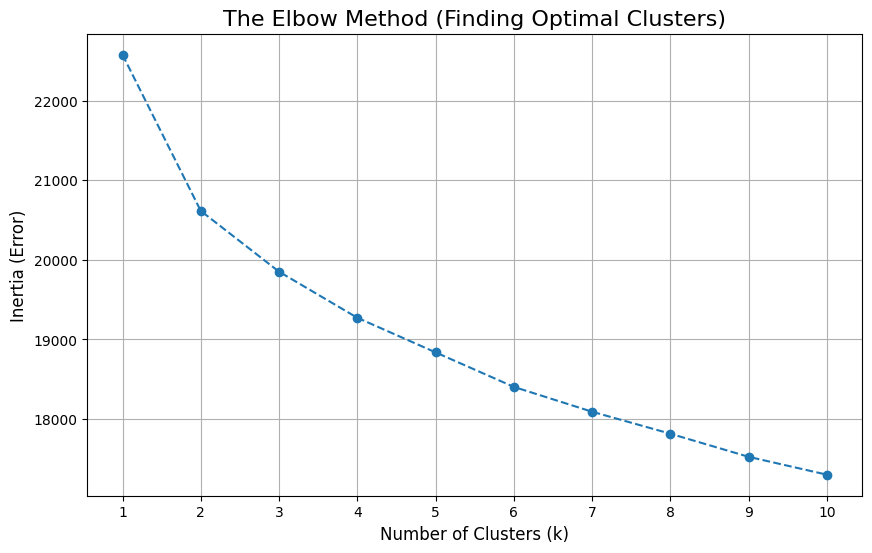

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- STEP 1: STANDARDIZATION ---
# Algorithms like K-Means need scaled data
feature_cols = [f'Q{i}' for i in range(1, 22)]
X = df[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- STEP 2: PCA (Dimensionality Reduction) ---
# Let's compress 21 dimensions down to 2 so we can visualize it later
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained Variance by 2 Components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")
# Note: Low variance here confirms the data is 'noisy', but we proceed.

# --- STEP 3: THE ELBOW METHOD ---
# We test K=1 to K=10 clusters to find the "sweet spot"
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# --- STEP 4: PLOT THE ELBOW ---
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding Optimal Clusters)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Error)', fontsize=12)
plt.xticks(K_range)
plt.grid(True)
plt.show()

## Support Vector Machine (SVM)

--- SVM Model Performance (Predicting Clusters) ---
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        90
           1       0.92      0.94      0.93        63
           2       0.93      0.89      0.91        62

    accuracy                           0.92       215
   macro avg       0.92      0.92      0.92       215
weighted avg       0.92      0.92      0.92       215


--- Confusion Matrix (SVM) ---
[[84  2  4]
 [ 4 59  0]
 [ 4  3 55]]


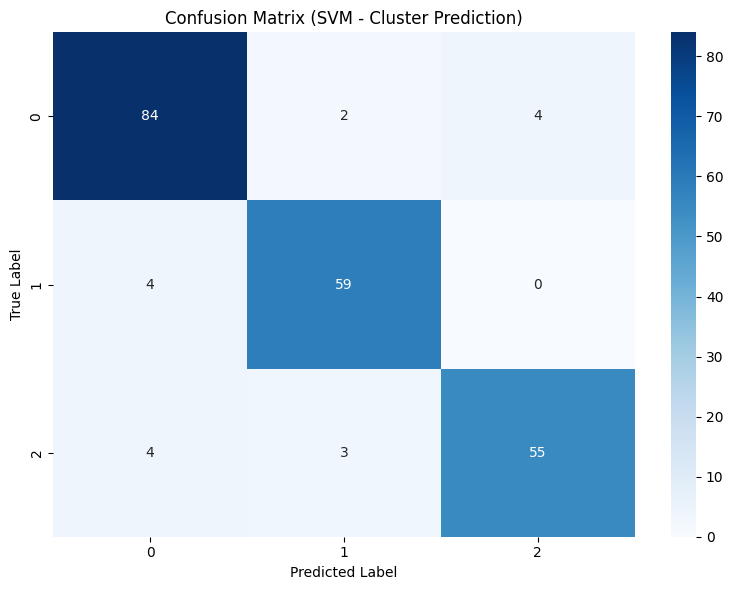


SVM Test Accuracy: 0.9209
SVM Test F1 Score (weighted): 0.9208
SVM Test Recall (weighted): 0.9209


In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# --- STEP 1: USE SAME FEATURES AND TARGET AS RANDOM FOREST ---
# Target = Cluster labels from K-Means
y_svm = df['Cluster']
# Features = Q1-Q21
X_svm = df[[f'Q{i}' for i in range(1, 22)]]

# Split (same split strategy for fair comparison)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

# --- STEP 2: SCALE FEATURES (SVM is sensitive to feature scales) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# --- STEP 3: TRAIN SVM CLASSIFIER ---
# Using RBF kernel (default); C=1.0, gamma='scale' for stability
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train_svm)

# --- STEP 4: EVALUATE ---
y_pred_svm = svm_model.predict(X_test_scaled)
print("--- SVM Model Performance (Predicting Clusters) ---")
print(classification_report(y_test_svm, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
print("\n--- Confusion Matrix (SVM) ---")
print(cm_svm)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test_svm.unique()),
            yticklabels=sorted(y_test_svm.unique()))
plt.title('Confusion Matrix (SVM - Cluster Prediction)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Accuracy, F1 score, Recall
from sklearn.metrics import accuracy_score, f1_score, recall_score
svm_accuracy = accuracy_score(y_test_svm, y_pred_svm)
svm_f1 = f1_score(y_test_svm, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test_svm, y_pred_svm, average='weighted')
print(f"\nSVM Test Accuracy: {svm_accuracy:.4f}")
print(f"SVM Test F1 Score (weighted): {svm_f1:.4f}")
print(f"SVM Test Recall (weighted): {svm_recall:.4f}")

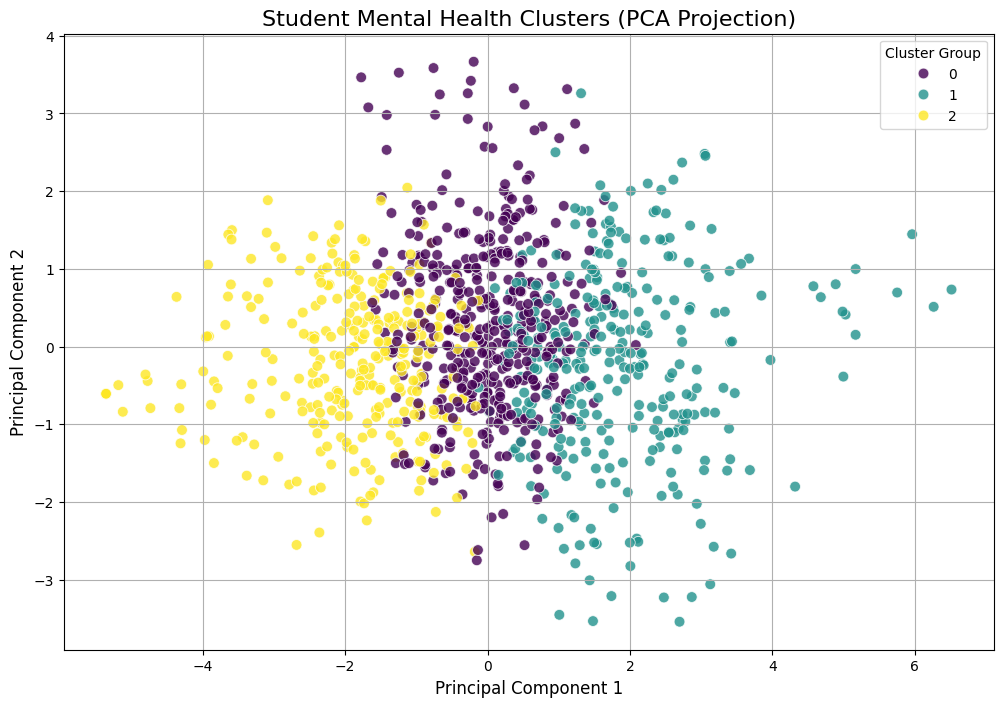


--- Cluster Profiles (Mean Scores) ---
         Depression_Score  Anxiety_Score  Stress_Score
Cluster                                               
0               17.398664      19.126949     19.077951
1               25.577287      23.678233     23.444795
2               11.462783      12.770227     11.676375

--- Cluster Sizes ---
Cluster
0    449
1    317
2    309
Name: count, dtype: int64

Cluster 0: Avg Dep=17.4, Anx=19.1, Stress=19.1

Cluster 1: Avg Dep=25.6, Anx=23.7, Stress=23.4

Cluster 2: Avg Dep=11.5, Anx=12.8, Stress=11.7


In [11]:
# --- STEP 1: APPLY K-MEANS CLUSTERING ---
# Based on the Elbow plot, k=3 is the most logical starting point
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# --- STEP 2: VISUALIZE CLUSTERS (PCA 2D Projection) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=60, alpha=0.8)
plt.title('Student Mental Health Clusters (PCA Projection)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster Group')
plt.grid(True)
plt.show()

# --- STEP 3: INTERPRET THE CLUSTERS (The "Novelty") ---
# We calculate the mean score of the original (Raw) DASS-21 scales for each cluster
# This tells us what defines each group.
cluster_profile = df.groupby('Cluster')[['Depression_Score', 'Anxiety_Score', 'Stress_Score']].mean()
cluster_counts = df['Cluster'].value_counts()

print("\n--- Cluster Profiles (Mean Scores) ---")
print(cluster_profile)
print("\n--- Cluster Sizes ---")
print(cluster_counts)

# Let's give them tentative names based on the scores
for i in range(3):
    d_score = cluster_profile.loc[i, 'Depression_Score']
    a_score = cluster_profile.loc[i, 'Anxiety_Score']
    s_score = cluster_profile.loc[i, 'Stress_Score']

    print(f"\nCluster {i}: Avg Dep={d_score:.1f}, Anx={a_score:.1f}, Stress={s_score:.1f}")

--- Model Performance (Predicting Clusters) ---
              precision    recall  f1-score   support

           0       0.78      0.86      0.81        90
           1       0.83      0.83      0.83        63
           2       0.89      0.76      0.82        62

    accuracy                           0.82       215
   macro avg       0.83      0.81      0.82       215
weighted avg       0.82      0.82      0.82       215


--- Confusion Matrix ---
[[77  8  5]
 [10 52  1]
 [12  3 47]]


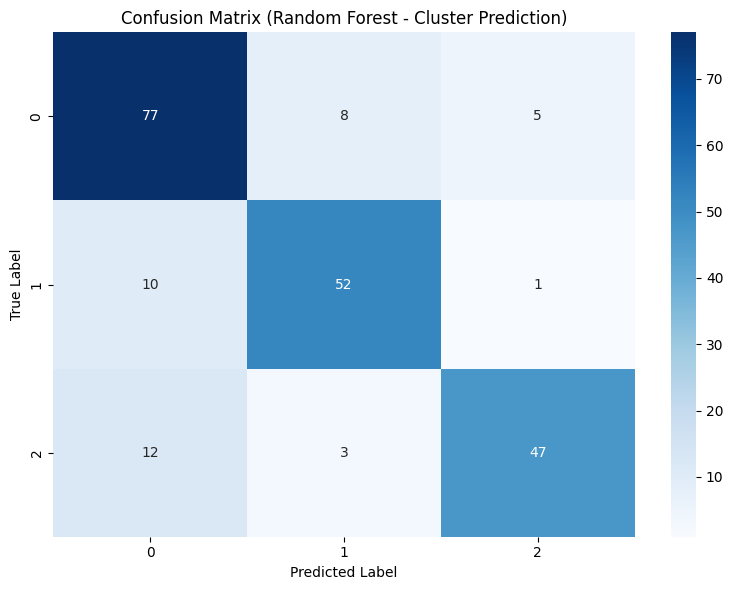


--- TOP 5 SYMPTOMS DRIVING THE CLUSTERS ---


,Question,Importance,Description
2,Q3,0.136011,No positive feelings
10,Q11,0.083465,Agitation
20,Q21,0.075610,Life meaningless
17,Q18,0.052409,Touchiness
11,Q12,0.048326,Diff. relaxing
19,Q20,0.047815,Unreasonable fear
15,Q16,0.046295,Lack of enthusiasm
12,Q13,0.045359,Down-hearted
4,Q5,0.043777,Lack of initiative
1,Q2,0.041273,Dryness of mouth


C:\Users\User\AppData\Local\Temp\ipykernel_7656\3398645016.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Description', data=imp_df.head(10), palette='magma')


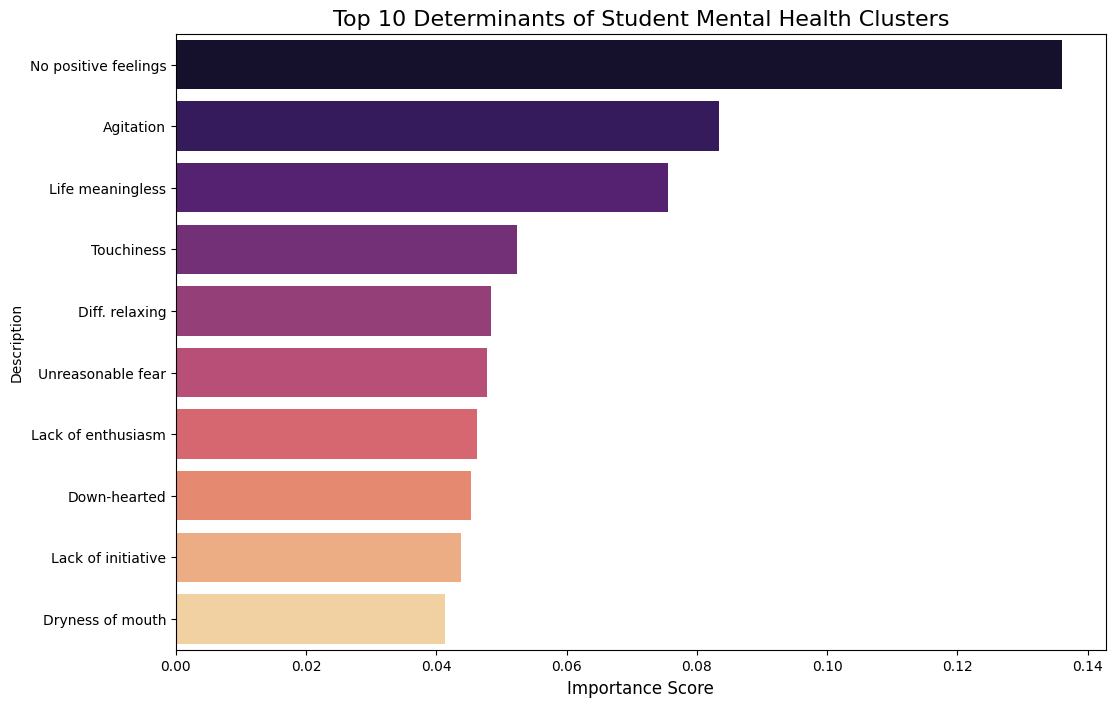

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- STEP 1: PREPARE DATA FOR SUPERVISED LEARNING ---
# Target = The Cluster we just discovered
y = df['Cluster']
# Features = The individual questions (Q1-Q21)
X = df[[f'Q{i}' for i in range(1, 22)]]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- STEP 2: TRAIN RANDOM FOREST ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- STEP 3: EVALUATE PERFORMANCE ---
# We need to verify the model actually learned the difference
y_pred = rf.predict(X_test)
print("--- Model Performance (Predicting Clusters) ---")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix ---")
print(cm)
# Visualize confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix (Random Forest - Cluster Prediction)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- STEP 4: EXTRACT FEATURE IMPORTANCE ---
# This is the "Key Finding" of your paper
importances = rf.feature_importances_
feature_names = [f'Q{i}' for i in range(1, 22)]

# Create a DataFrame to sort and visualize
imp_df = pd.DataFrame({'Question': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# Map the Question Numbers back to the Text (from your first message) for readability
q_map = {
    'Q1': 'Hard to wind down', 'Q2': 'Dryness of mouth', 'Q3': 'No positive feelings',
    'Q4': 'Breathing difficulty', 'Q5': 'Lack of initiative', 'Q6': 'Over-reacting',
    'Q7': 'Trembling', 'Q8': 'Nervous energy', 'Q9': 'Fear of panic',
    'Q10': 'Nothing to look forward', 'Q11': 'Agitation', 'Q12': 'Diff. relaxing',
    'Q13': 'Down-hearted', 'Q14': 'Intolerance to interrupt', 'Q15': 'Close to panic',
    'Q16': 'Lack of enthusiasm', 'Q17': 'Low self-worth', 'Q18': 'Touchiness',
    'Q19': 'Heart awareness', 'Q20': 'Unreasonable fear', 'Q21': 'Life meaningless'
}
imp_df['Description'] = imp_df['Question'].map(q_map)

print("\n--- TOP 5 SYMPTOMS DRIVING THE CLUSTERS ---")
display(imp_df.head(10))

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Description', data=imp_df.head(10), palette='magma')
plt.title('Top 10 Determinants of Student Mental Health Clusters', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.show()

In [14]:
from scipy.stats import chi2_contingency

# --- STEP 1: GENDER DISTRIBUTION PER CLUSTER ---
# Create a contingency table (Cluster vs Gender)
gender_crosstab = pd.crosstab(df['Cluster'], df['Gender'])

print("\n--- Gender Distribution by Cluster (Raw Counts) ---")
display(gender_crosstab)

print("\n--- Gender Distribution by Cluster (Percentages) ---")
# Show percentages across the row (Cluster)
display(gender_crosstab.div(gender_crosstab.sum(1), axis=0) * 100)

# --- STEP 2: STATISTICAL SIGNIFICANCE (Chi-Square Test) ---
# Null Hypothesis: Gender and Mental Health Cluster are NOT related.
# Alternate Hypothesis: There IS a significant relationship.
chi2, p, dof, expected = chi2_contingency(gender_crosstab)

print("\n--- Chi-Square Test Results ---")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4e}")

if p < 0.05:
    print("✅ RESULT: Statistically Significant! Gender influences which cluster a student falls into.")
else:
    print("❌ RESULT: Not Significant. Gender does not appear to drive these clusters.")

# --- STEP 3: AGE ANALYSIS ---
# Quick check if Age varies by cluster
print("\n--- Average Age by Cluster ---")
print(df.groupby('Cluster')['Age'].describe()[['count', 'mean', 'std']])


--- Gender Distribution by Cluster (Raw Counts) ---


Gender,Female,Male
Cluster,,
0,243,206
1,118,199
2,141,168



--- Gender Distribution by Cluster (Percentages) ---


C:\Users\User\AppData\Local\Temp\ipykernel_7656\274914424.py:12: Pandas4Warning: Starting with pandas version 4.0 all arguments of sum will be keyword-only.
  display(gender_crosstab.div(gender_crosstab.sum(1), axis=0) * 100)


Gender,Female,Male
Cluster,,
0,54.120267,45.879733
1,37.223975,62.776025
2,45.631068,54.368932



--- Chi-Square Test Results ---
Chi-Square Statistic: 21.5099
P-Value: 2.1339e-05
✅ RESULT: Statistically Significant! Gender influences which cluster a student falls into.

--- Average Age by Cluster ---
         count       mean       std
Cluster                            
0        449.0  22.278396  2.156904
1        317.0  22.984227  3.469086
2        309.0  22.983819  3.487882


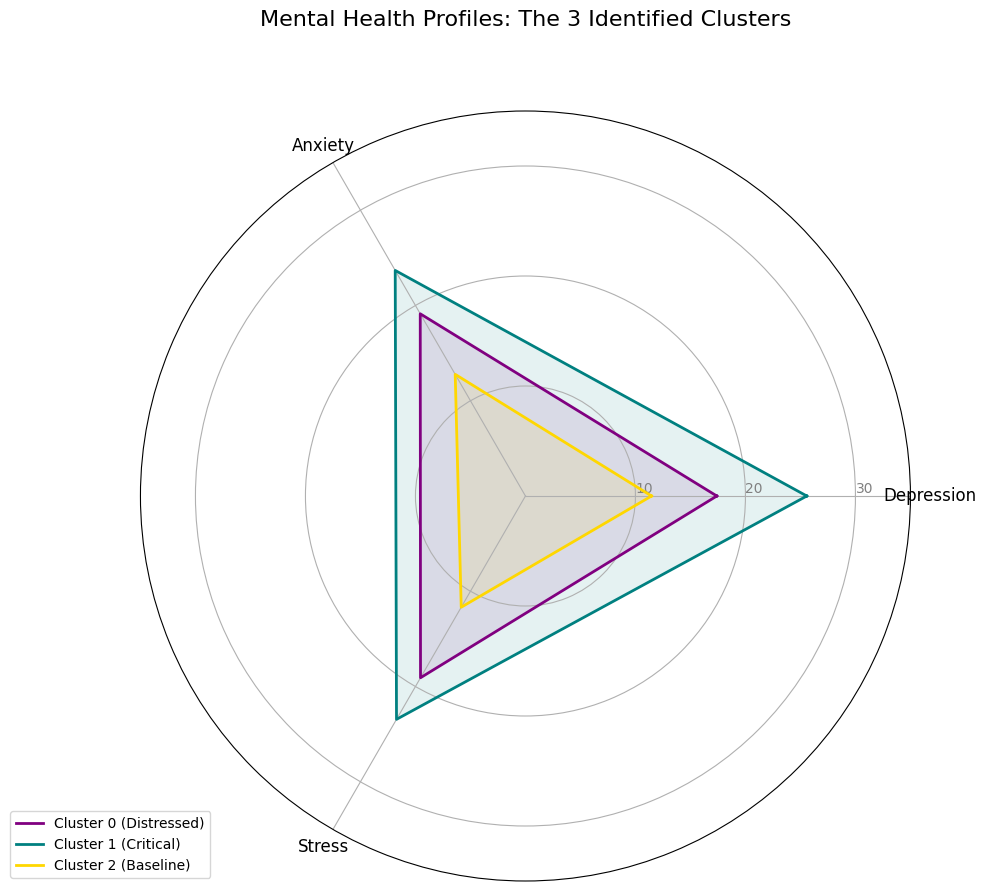

In [15]:
import numpy as np

# --- STEP 1: PREPARE DATA ---
# We use the mean scores of the 3 sub-scales for each cluster
cluster_means = df.groupby('Cluster')[['Depression_Score', 'Anxiety_Score', 'Stress_Score']].mean()

# Normalization (Min-Max Scaling) so they fit nicely on the chart (0 to 1 scale)
# This highlights the *relative* shape of the distress
# Note: You can also plot raw scores, but normalized looks cleaner for "profiles"
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

# Let's plot the RAW scores to be scientifically accurate for the paper
categories = ['Depression', 'Anxiety', 'Stress']
N = len(categories)

# --- STEP 2: BUILD THE RADAR CHART ---
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# What are the angles for each axis?
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Close the loop

# Draw one line per cluster
colors = ['purple', 'teal', 'gold']
labels = ['Cluster 0 (Distressed)', 'Cluster 1 (Critical)', 'Cluster 2 (Baseline)']

for i in range(3):
    # Get the data for this cluster
    values = cluster_means.iloc[i].values.flatten().tolist()
    values += values[:1] # Close the loop

    # Plot
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# --- STEP 3: FORMATTING ---
plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([10, 20, 30], ["10", "20", "30"], color="grey", size=10)
plt.ylim(0, 35) # DASS scores usually max out around 42

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Mental Health Profiles: The 3 Identified Clusters', size=16, y=1.1)

plt.show()